![toy](assets/my-first/toy.jpg)

(image: flickr)

# My first machine learning model

In this workshop, we will walk through creating and training a simple machine learning model from scratch.

Through out the course, we'll be repeating the tasks in this process for different machine learning algorithms.

### Data Science Process

![workflow](assets/intro/ds.png)

(image: szilard)

### What we will cover today

1. Data transformation and cleaning
2. Feature selection
3. Model creation and training
4. Model validation
5. Undestanding results and iterating

### Data Source

Monthly Certificate of Entitlement (COE) Bidding Results Dataset over the past few years.

1. Download the dataset from https://data.gov.sg/dataset/coe-bidding-result
2. Extract the data and note down the path for use later

### Prediction Task

Predict the COE Premium (S$) based on Vehicle Class, Quota, Number of Received Bids, and Number of Successful Bids.

We'll try **Linear Regression**.

### Linear Regression

We'll cover linear regression in more detail in the next module. For now, you can think of it as finding a function $f$ such that:

$$PredictedPremium = f(VehicleClass, Quota, NumReceivedBids, NumSuccessfulBids)$$

Where $f(...)$ is a linear equation ($y = Wx + b$):

$$PredictedPremium = w1*VehicleClass + w2 * Quota + w3 * NumReceivedBids + w4 * NumSuccessfulBids + b$$

The goal of training Linear Regression is to:
- find the values of $w1, ... w4$, and $b$
- ... so that $PredictedPremium$ is as close as possible to $ActualPremium$.

### 1. Data Transformation and Cleaning

The first step is to inspect the data using Pandas.

The goal is to transform the data into features we will use for our model.

In [38]:
import pandas as pd

df = pd.read_csv('D:/tmp/coe-bidding-results/coe-results.csv')
df.describe()

,bidding_no,quota,bids_success,bids_received,premium
count,985.000000,985.000000,985.000000,985.000000,985.000000
mean,1.497462,551.541117,542.492386,828.330964,46445.775635
std,0.500248,452.628678,450.746689,686.769488,26065.702205
min,1.000000,140.000000,126.000000,196.000000,852.000000
25%,1.000000,294.000000,285.000000,417.000000,31006.000000
50%,1.000000,373.000000,368.000000,549.000000,50502.000000
75%,2.000000,559.000000,547.000000,902.000000,65001.000000
max,2.000000,2272.000000,2246.000000,4545.000000,97889.000000


In [39]:
df.head()

,month,bidding_no,vehicle_class,quota,bids_success,bids_received,premium
0,2010-01,1,Category A,1152,1145,1342,18502
1,2010-01,1,Category B,687,679,883,19190
2,2010-01,1,Category C,173,173,265,19001
3,2010-01,1,Category D,373,365,509,889
4,2010-01,1,Category E,586,567,1011,19889


In [40]:
df.tail()

,month,bidding_no,vehicle_class,quota,bids_success,bids_received,premium
980,2018-03,1,Category A,1580,1572,2405,38830
981,2018-03,1,Category B,1390,1390,1731,39001
982,2018-03,1,Category C,247,202,446,36003
983,2018-03,1,Category D,528,525,885,8009
984,2018-03,1,Category E,571,525,967,39000


The data is monthly, from 2010 until 2018.

Let's inspect the other columns to see which ones we would like to use.

In [41]:
for column_name in df.columns:
    print('\nColumn:', column_name)
    print(df[column_name].describe())


Column: month
count         985
unique         99
top       2012-03
freq           10
Name: month, dtype: object

Column: bidding_no
count    985.000000
mean       1.497462
std        0.500248
min        1.000000
25%        1.000000
50%        1.000000
75%        2.000000
max        2.000000
Name: bidding_no, dtype: float64

Column: vehicle_class
count            985
unique             5
top       Category B
freq             197
Name: vehicle_class, dtype: object

Column: quota
count     985.000000
mean      551.541117
std       452.628678
min       140.000000
25%       294.000000
50%       373.000000
75%       559.000000
max      2272.000000
Name: quota, dtype: float64

Column: bids_success
count     985.000000
mean      542.492386
std       450.746689
min       126.000000
25%       285.000000
50%       368.000000
75%       547.000000
max      2246.000000
Name: bids_success, dtype: float64

Column: bids_received
count     985.000000
mean      828.330964
std       686.769488
min      

### Data Processing Steps

From above, here's the data processing / transformation we should consider before we start doing any training:

|Data Column|Processing/Transformation Step|Reason|
|--|--|--|
|vehicle_class|Convert to numerical representation|The words have no semantic meaning beyond a label|
|month|Consider dropping column from dataset|If the series is not time dependent, we do not need to include the month|
|All remaining input columns|Center the values and scale to within same range|To equalize the ranges and speed up training|

### A. Convert categorical data to numbers

For `vehicle_class` we'll try `pandas.get_dummies()` to convert the 5-category variable into 5 columns of indicator variables.

Using indicator variables instead of 1-5 will ensure that the categories are given equal weight when we start training.

In [42]:
df = pd.get_dummies(df, columns=['vehicle_class'], sparse=True)
df.head()

,month,bidding_no,quota,bids_success,bids_received,premium,vehicle_class_Category A,vehicle_class_Category B,vehicle_class_Category C,vehicle_class_Category D,vehicle_class_Category E
0,2010-01,1,1152,1145,1342,18502,1,0,0,0,0
1,2010-01,1,687,679,883,19190,0,1,0,0,0
2,2010-01,1,173,173,265,19001,0,0,1,0,0
3,2010-01,1,373,365,509,889,0,0,0,1,0
4,2010-01,1,586,567,1011,19889,0,0,0,0,1


### B. Determining time dependence

We will run a quick test to determine if the outcome (`premium`) is time dependent.

The quick test is to **plot the auto-correlation of the "premium" column**.

Auto-correlation will be covered in detail in a later module, under Time Series. For now, all you need to know is that "correlation" measures how closely-related (i.e. correlated) the current value at time `t` is with its previous values.  We use "lag" to indicate how far back in time to go.  So time `t-1` means a lag of 1.

By plotting the auto-correlation, we can check quickly to see if a given series is truly random over time.

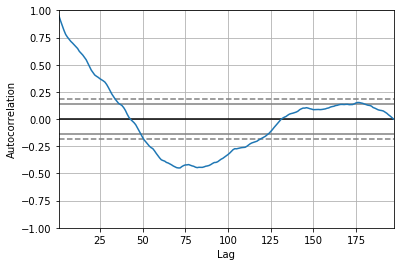

In [43]:
# get auto-correlation for COE premium column, choosing an example class category
series = df.loc[df['vehicle_class_Category A']==1, 'premium'].values

pd.plotting.autocorrelation_plot(series)

### Removing time-dependence

The plot above shows that for lag values below 35, there's quite a strong correlation, unfortunately.

Ideally, we want a plot that looks more like this:
![random](assets/my-first/random-autocorrelation.png)


#### Implications of time-dependence on a series you are trying to predict:
1. Linear regression on the entire series over time is **not** appropriate. This is because the time series will overpower, and the linear-regression prediction based on other variables will not be accurate.

2. Instead, we can model a simple linear regression for values **within the same time period**

Let's restate our machine learning problem.

### Prediction Task (Re-stated)

**For a fixed time period**, predict the COE Premium (S$) based on Vehicle Class, Quota, Number of Received Bids, and Number of Successful Bids.

We'll be using Linear Regression and only choosing 

In [46]:
df.columns

Index(['month', 'bidding_no', 'quota', 'bids_success', 'bids_received',
       'premium', 'vehicle_class_Category A', 'vehicle_class_Category B',
       'vehicle_class_Category C', 'vehicle_class_Category D',
       'vehicle_class_Category E'],
      dtype='object')

In [48]:
df['bid_ratio'] = df['bids_success'] / df['bids_received']

In [49]:
df.head()

,month,bidding_no,quota,bids_success,bids_received,premium,vehicle_class_Category A,vehicle_class_Category B,vehicle_class_Category C,vehicle_class_Category D,vehicle_class_Category E,bid_ratio
0,2010-01,1,1152,1145,1342,18502,1,0,0,0,0,0.853204
1,2010-01,1,687,679,883,19190,0,1,0,0,0,0.768969
2,2010-01,1,173,173,265,19001,0,0,1,0,0,0.652830
3,2010-01,1,373,365,509,889,0,0,0,1,0,0.717092
4,2010-01,1,586,567,1011,19889,0,0,0,0,1,0.560831


In [52]:
df_c = df[df['vehicle_class_Category C'] == 1]

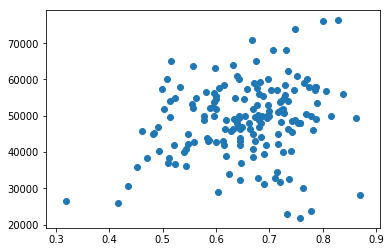

In [57]:
import matplotlib.pyplot as plt

plt.scatter(df_c[30:].bid_ratio, df_c[30:].premium)